## Introduction
 how to handle DICOM files in python.<br />
To fulfill this task we use a subset of CT images from the Cancer Imaging Archive TCIA (1, 2)<br />(https://www.kaggle.com/kmader/siim-medical-images) containing single CT slices.<br />
We already provide a sample file in this folder

If you want to download the data, log in to kaggle, navigate to this page: https://www.kaggle.com/kmader/siim-medical-images?select=dicom_dir and click on download

(1) Albertina, B., Watson, M., Holback, C., Jarosz, R., Kirk, S., Lee, Y., … Lemmerman, J. (2016). Radiology Data from The Cancer Genome Atlas Lung Adenocarcinoma [TCGA-LUAD] collection. The Cancer Imaging Archive. http://doi.org/10.7937/K9/TCIA.2016.JGNIHEP5

(2) Clark K, Vendt B, Smith K, Freymann J, Kirby J, Koppel P, Moore S, Phillips S, Maffitt D, Pringle M, Tarbox L, Prior F. The Cancer Imaging Archive (TCIA): Maintaining and Operating a Public Information Repository, Journal of Digital Imaging, Volume 26, Number 6, December, 2013, pp 1045-1057. (paper)

(Data License: http://creativecommons.org/licenses/by/3.0/)

First we import the necessary libraries and set the path to the directory containing the DICOM files

## Imports
* pathlib for easy path handling
* pydicom to handle dicom files
* matplotlib for visualization
* numpy to create the 3D container

In [11]:
!git clone https://github.com/sm-multimedia/Deep-learning-in-medical-imaging-analysis.git

Cloning into 'Deep-learning-in-medical-imaging-analysis'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 33 (delta 2), reused 31 (delta 0), pack-reused 0
Unpacking objects: 100% (33/33), done.


In [3]:
!pip install pydicom

     |████████████████████████████████| 2.0 MB 4.2 MB/s 


In [4]:
from pathlib import Path

import pydicom 
import matplotlib.pyplot as plt
import numpy as np

At first we try to read a single dcm file <br />
To this end we use the **read_file(path)** function provided by pydicom

In [5]:
sample_dcm = "/content/data/ID_0000_AGE_0060_CONTRAST_1_CT.dcm"
dicom_file = pydicom.read_file(sample_dcm)  # read single dicom file

Let's take a look what this file contains. <br />
You can *print* the dicom file to get a bulk of information, containing e.g the company which built the scanner (SIEMENS in this case), the shape of the image (*Rows, Columns*, 512x512 in this case), table height all information about the patient (of course the personal information is anonymized here), and of large importance, the **image orientation**

Feel free to scroll through the available information

In [6]:
print(dicom_file)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 194
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.14519.5.2.1.7777.9002.108821836759549281694712274169
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'dcm4che-1.4.31'
-------------------------------------------------
(0008, 0000) Group Length                        UL: 430
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.14519.5.2.1.7777.9002.1088

Accessing DICOM **header** information:
You can access the dicom tags by using the hexadecimal encoded identifiers at the start of each line.
As an example, if you want to get the shape of the image you can use those two identifiers

* (0028, 0010) Rows
* (0028, 0011) Columns
* (0018, 0015) Body Part Examined

The 0x in front of the identifier tells the python interpreter that it should interpret this value as hexadecimal

In [7]:
print(dicom_file[0x0028, 0x0010])
print(dicom_file[0x0028, 0x0011])
print(dicom_file[0x0018, 0x0015])

(0028, 0010) Rows                                US: 512
(0028, 0011) Columns                             US: 512
(0018, 0015) Body Part Examined                  CS: 'CHEST'


There is an alternative, more direct way to access the values of the DICOM header tags using the tag descriptions
    <br /> Please note the lettering: 'Body Part Examined' becomes 'BodyPartExamined' (so-called Pascal Case):

In [8]:
print('Rows: ', dicom_file.Rows)
print('Columns: ', dicom_file.Columns)
print('Body Part Examined: ', dicom_file.BodyPartExamined)

Rows:  512
Columns:  512
Body Part Examined:  CHEST


Accessing DICOM **body** information (the actual image):

The **pixel_array** contains the actual image data:

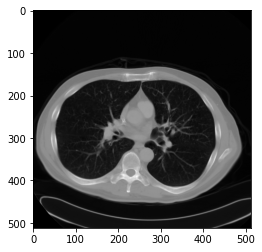

In [9]:
ct = dicom_file.pixel_array # load the image pixel data as a numpy array
plt.figure()
plt.imshow(ct, cmap="gray")

We can perform a quick sanity check and make sure that the image shape corresponds to the Rows and Columns we saw earlier in the header information (512x512)

In [10]:
print(ct.shape)

(512, 512)


## 3D Data
In this section we will take a look at a full head MRI scan, so that you learn how to handle 3D Data stored as multiple 2D DICOM files.

The data is taken from here (https://zenodo.org/record/16956#.YFMM5PtKiV5) (3) and again provided in this directory
<br />
You can download it directly from the link by clicking the download button next to the preview button.<br />
Again we unzip the directory after obtaining it.

Typically there is one file for each slice, thus we need to read all files and append the slices to a list

(3)Lionheart, W. R. B. (2015). An MRI DICOM data set of the head of a normal male human aged 52 [Data set]. Zenodo. http://doi.org/10.5281/zenodo.16956 (Data License: Creative Commons Attribution Share Alike 4.0 International <br />https://creativecommons.org/licenses/by-sa/4.0/legalcode)



In [12]:
path_to_head_mri = Path("/content/Deep-learning-in-medical-imaging-analysis/SE000001")

We can use the glob function to return all items in a directory which correspond to the provided pattern. <br />
As in this case, the directory only contains the DICOM files, we can return all files in it ("*")

In [13]:
all_files = list(path_to_head_mri.glob("*"))  # as glob returns a generator, we convert it to a list

In [14]:
all_files  # make sure that all files are present in the list

[PosixPath('/content/Deep-learning-in-medical-imaging-analysis/SE000001/MR000003'),
 PosixPath('/content/Deep-learning-in-medical-imaging-analysis/SE000001/MR000024'),
 PosixPath('/content/Deep-learning-in-medical-imaging-analysis/SE000001/MR000012'),
 PosixPath('/content/Deep-learning-in-medical-imaging-analysis/SE000001/MR000001'),
 PosixPath('/content/Deep-learning-in-medical-imaging-analysis/SE000001/MR000018'),
 PosixPath('/content/Deep-learning-in-medical-imaging-analysis/SE000001/MR000013'),
 PosixPath('/content/Deep-learning-in-medical-imaging-analysis/SE000001/MR000021'),
 PosixPath('/content/Deep-learning-in-medical-imaging-analysis/SE000001/MR000019'),
 PosixPath('/content/Deep-learning-in-medical-imaging-analysis/SE000001/MR000000'),
 PosixPath('/content/Deep-learning-in-medical-imaging-analysis/SE000001/MR000014'),
 PosixPath('/content/Deep-learning-in-medical-imaging-analysis/SE000001/MR000016'),
 PosixPath('/content/Deep-learning-in-medical-imaging-analysis/SE000001/MR00

Now we will read these files by using the read_file method and append them to a list

In [15]:
mri_data = []

for path in all_files:
    data = pydicom.read_file(path) # read the single DICOM files
    mri_data.append(data)
print(len(mri_data))

27


As you can see from the printed paths above, it is possible that the DICOM files are not ordered according to their actual image position! <br />
This can be verified by inspecting the SliceLocation

In [16]:
### unordered slices ###
for slice in mri_data[:5]: # just show the first 5 slices
    print(slice.SliceLocation) # this is the location of the within the scanner coordinate system

17.9999979772582
143.999998928727
71.9999961590453
5.99999663091323
107.999995419197


It crucial to order them, as otherwise your complete scan would be shuffeled and useless

We can use the "SliceLocation" attribute passed to the *sorted* function to identify the 2D slice position and thus order the slices

In [17]:
# this sorts the slices according to their location
mri_data_ordered = sorted(mri_data, key=lambda slice: slice.SliceLocation) 

### Ordered slices ###
for slice in mri_data_ordered[:5]:
    print(slice.SliceLocation)

0.0
5.99999663091323
11.9999973042441
17.9999979772582
23.9999946081714


Now we extract the actual data (pixel_arrays) from the Dicom files and store them in a list

In [18]:
full_volume = []
for slice in mri_data_ordered:
    full_volume.append(slice.pixel_array) # fill the 3D array in a slice-per-slice manner
full_volume = np.array(full_volume)
print(full_volume.shape)

(27, 256, 256)


And now we can take a look at some slices of the ordered 3D volume:

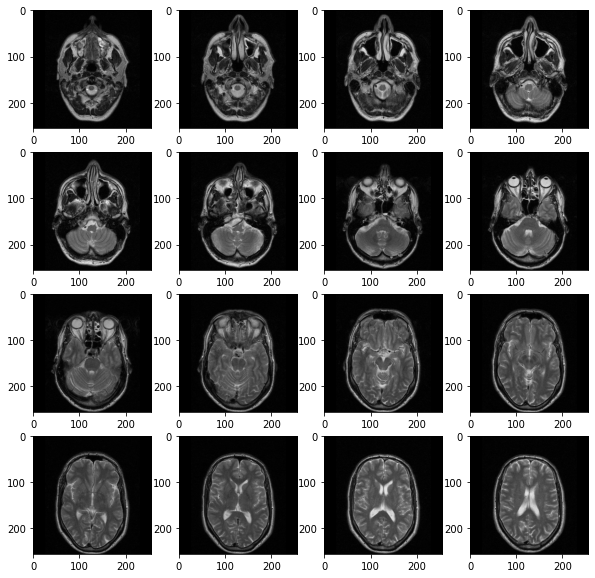

In [21]:
fig, axis = plt.subplots(4, 4, figsize=(10, 10))

slice_counter = 0
for i in range(4):
    for j in range(4):
        axis[i][j].imshow(full_volume[slice_counter], cmap="gray")
        slice_counter+=1

**Awesome!** <br />
We now have a way to handle 2D and 3D data stored in the DICOM format

But (as you will have noticed), manual file reading and ordering seems kind of tedious, it would be great if there was a tool which handles this for us.

There is, and its name is SimpleITK https://pypi.org/project/SimpleITK/

SimpleITK provides functionality to automatically detect and read all dicom files without you managing the file reading or slice ordering

The overall routine is always identical

1. Get Series Ids of all files in the directory. This is important as there also might be multiple scans in the same directory and we do not want to mix them. *ImageSeriesReader.GetGDCMSeriesIDs(path)* handles this and returns all Ids it can find
2. Then we return all file names in the directory which have our desired Id *ImageSeriesReader.GetGDCMSeriesFileNames(path, ID)* provides this functionality
3. We then define the image reader called *ImageSeriesReader()* and feed it the file names using *SetFileNames(file_names)*
4. Finally we execute the reader in order to get our desired data by calling *Execute()*

Let's go:<br />
At first we import the necessary libraries:

## Imports
* SimpleITK to read 3D volumes in dcm format

In [23]:
!pip install SimpleITK

     |████████████████████████████████| 48.4 MB 2.5 MB/s 


In [24]:
import SimpleITK as sitk

In [25]:
series_ids = sitk.ImageSeriesReader.GetGDCMSeriesIDs(str(path_to_head_mri))
print(series_ids)

('1.3.46.670589.11.0.0.11.4.2.0.12098.5.4500.2015011413262801702',)


In [26]:
series_file_names = sitk.ImageSeriesReader.GetGDCMSeriesFileNames(str(path_to_head_mri), series_ids[0])
series_file_names  # Notice how the files are already ordered

('/content/Deep-learning-in-medical-imaging-analysis/SE000001/MR000000',
 '/content/Deep-learning-in-medical-imaging-analysis/SE000001/MR000001',
 '/content/Deep-learning-in-medical-imaging-analysis/SE000001/MR000002',
 '/content/Deep-learning-in-medical-imaging-analysis/SE000001/MR000003',
 '/content/Deep-learning-in-medical-imaging-analysis/SE000001/MR000004',
 '/content/Deep-learning-in-medical-imaging-analysis/SE000001/MR000005',
 '/content/Deep-learning-in-medical-imaging-analysis/SE000001/MR000006',
 '/content/Deep-learning-in-medical-imaging-analysis/SE000001/MR000007',
 '/content/Deep-learning-in-medical-imaging-analysis/SE000001/MR000008',
 '/content/Deep-learning-in-medical-imaging-analysis/SE000001/MR000009',
 '/content/Deep-learning-in-medical-imaging-analysis/SE000001/MR000010',
 '/content/Deep-learning-in-medical-imaging-analysis/SE000001/MR000011',
 '/content/Deep-learning-in-medical-imaging-analysis/SE000001/MR000012',
 '/content/Deep-learning-in-medical-imaging-analysi

In [27]:
series_reader = sitk.ImageSeriesReader()
series_reader.SetFileNames(series_file_names)

In [28]:
image_data = series_reader.Execute()

In [29]:
print(image_data.GetSize()) # show the size of the 3D image array

(256, 256, 27)


### This is all you have to do, to get your full volumetric data
As you can see, the shape is (256, 256, 27), whereas above the shape was (27, 256, 256). 
This is just due to a different order of image dimensions. <br />

The final step we have to perform is the conversion of the sitk image object to a numpy array. This can be done by calling *GetArrayFromImage(image_data)*

In [31]:
head_mri = sitk.GetArrayFromImage(image_data)
print(type(head_mri))
print(head_mri.shape)

<class 'numpy.ndarray'>
(27, 256, 256)


As you can see, it also directly moved the slice channel to the front - Great!
Now we can take a look at our images and as you can see the result is identical to the one above!

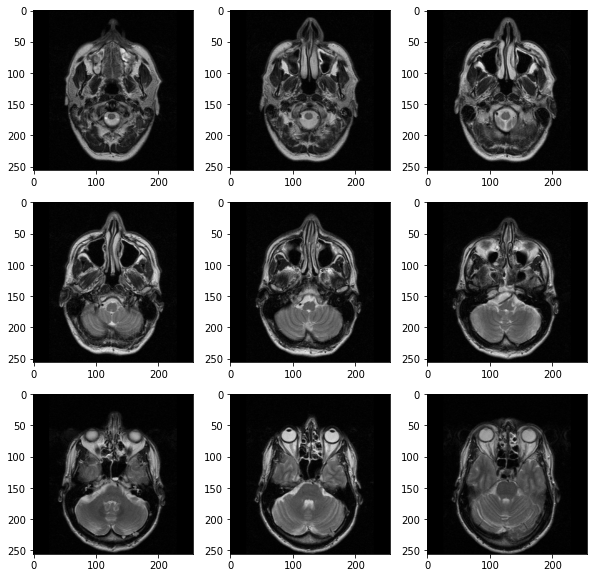

In [32]:
fig, axis = plt.subplots(3, 3, figsize=(10, 10))

slice_counter = 0
for i in range(3):
    for j in range(3):
        axis[i][j].imshow(head_mri[slice_counter], cmap="gray")
        slice_counter+=1